# Filter Testing
The goal of this pre-processing file is to determine what filter and parameters are most likely to make it easier to segment the dataset. For my project, I determined that the unsharp masking filter worked the best and that is what I implemented in the main segmentation workflow. If a different filter works better for your dataset, copy that function in the main segmentation workflow instead of the unsharp_mask function

First, we need to import some packages and connect to google drive to access the data

In [1]:
import numpy as np
import skimage as sk
import matplotlib.pyplot as plt
import os

# mount drive- following tutorial at https://medium.com/ml-book/simplest-way-to-open-files-from-google-drive-in-google-colab-fae14810674
from google.colab import drive
drive.mount('/content/drive')
 


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Next, we need to import the image we will be looking at. Here we load it in, convert it to a grayscale image, and visualize it. The outputs of this cell are the shape of the image (check to make sure it is only two dimensional) and a visualization of the image to make sure the expected image is what loaded

(506, 496)


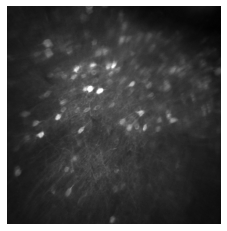

In [2]:
# import image
from skimage import color

im_dir='drive/My Drive/CHEME 599/Project/images'; # image path to open
fname='PL01_day1.tif' # file name to open
  
im=plt.imread(os.path.join(im_dir, fname)); # read image 


im=color.rgb2gray(im) # convert the image to grayscale
print(im.shape) # ensure the image is 2-dimensional (i.e. grayscale)

fig, ax=plt.subplots(figsize=(4,4)) # prepare plot of image
ax.imshow(im, cmap='gray')  # plot the image
ax.axis('off'); # remove axis labels, semicolon suppresses text output 

#Spatial Domain

First, we will assess different filters of the image in the spatial domain. Most spatial domain filters are build into `scikit image` in a single line and do not require functions.

One filter, unsharp masking which removes a filtered background image from the input image does not have a built in function and we need to define one. We do so below:

In [3]:
def unsharp_mask(im, scale): 
  ''' Perform unsharp masking on an image

  Generates a sharper image `im_us` from input image `im`
  by removing slowly varying background noise. Background
  noise is calculated using a width of 1/`scale` of the 
  image width. Rescales the resulting image to take adavantage
  of a wider range of pixel fluorescence available. 
    

  Parameters
  ----------
  im : a grayscale image
      color images should be converted using rgb2gray
  scale : int
      an integer describing the width of the box used
      to blur the image. The box will be 1/`scale` times
      the image width wide

  Returns
  -------
  im_us
      an ubyte image that representes `im` unsharp masked
      using an image with mask width  `scale`
    
  Notes
  -----
    Uses mean filter to create the background image 

  Examples
  --------
  #denoise grayscale cameraman image
  from skimage import data
  im=data.camera() # load cameraman image
  im_us=unsharp_mask(im,2) # perform unsharp masking...
  #with mean filter with scale box 1/2 im width
  plt.imshow(im_us) # show the resulting image 

  #denoise color image 
  from skimage import data, color
  im=sk.data.chelsea()
  im=sk.color.rgb2gray(im) # convert to grayscale
  im_us=unsharp_mask(im,40)
  plt.imshow(im_us)
  '''
  im=img_as_ubyte(im) # ensure the image is in uint8 form
  length=int((np.round(im.shape[1]/scale,0))); # set filter size to 1/ scaling factor of image size 
  selem=square(length) # create mask that is half as wide as the image rounded up
  background=1.0*rank.mean(im, selem) # generate the background image
  im_us=im-background # subtract background from main image
  # normalize the image fluoresence
  im_min=np.min(im_us)
  im_range = np.max(im_us)-im_min
  im_us = np.round(255*(im_us - im_min)/im_range, 0) # normalize
  return(im_us)

Now, we need to perform and visualize the spatial filters to enhance our image. We will try three filters:
- mean filter: `im_mean`
- median filter: `im_med`
- laplacian filter: `im_lap`

We also try enhancing image edges by adding the laplacian filtered image back ontop of the orignal image (`lap_plus`)

We visualize the output in a plot. From these images, it is clear that the unsharp masking does the best job enhancing the difference in neurons and background. 

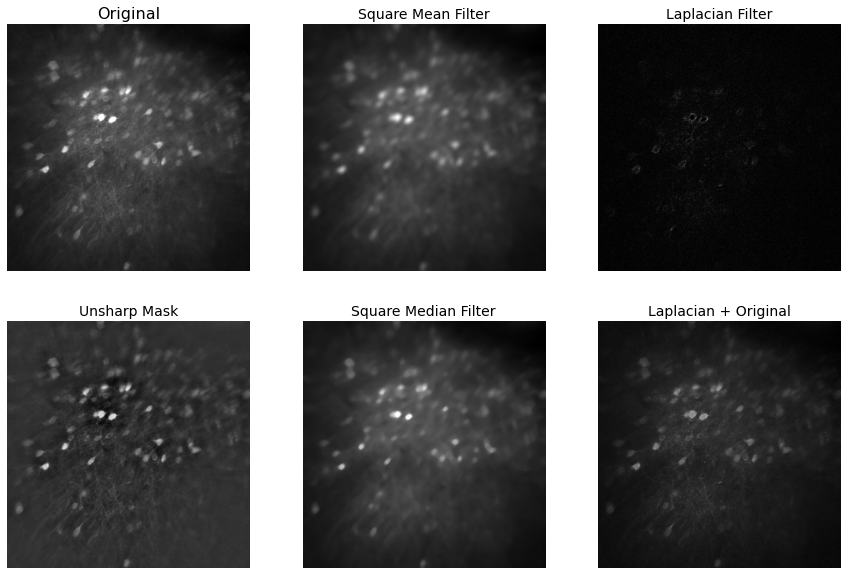

In [4]:
# test spatial filters
from skimage.morphology import square, disk, star
from skimage.filters import rank
from skimage.util import img_as_float, img_as_ubyte
from skimage.filters import laplace


im_us=unsharp_mask(im,10) # use the unsharp masking function on the image

im=img_as_ubyte(im)
selem=square(10) # make a 10x10 square of ones 
im_mean=rank.mean(im, selem=selem) # create image filtered with square mean spatial filter
im_med=rank.median(im, selem=selem) # create image filtered with square median spatial filter 

im_lap=laplace(im, ksize=3) # create structural element for laplacian filter
im_lap=np.abs(im_lap) # take absolute value of edge image-- just want edges not direction 
lap_plus=img_as_float(im)+im_lap; # add the laplacian filtered image to the image to sharpen edges



fig, ax=plt.subplots(figsize=(15, 10) , ncols=3, nrows=2)

ax[0,0].imshow(im, cmap='gray')
ax[0,0].set_title('Original',fontsize=16)
ax[0,0].axis('off')

ax[1,0].imshow(im_us, cmap='gray')
ax[1,0].set_title('Unsharp Mask', fontsize=14)
ax[1,0].axis('off');

ax[0,1].imshow(im_mean, cmap='gray')
ax[0,1].set_title('Square Mean Filter',fontsize=14)
ax[0,1].axis('off')

ax[1,1].imshow(im_med, cmap='gray')
ax[1,1].set_title('Square Median Filter', fontsize=14)
ax[1,1].axis('off');

ax[0,2].imshow(im_lap, cmap='gray')
ax[0,2].set_title('Laplacian Filter',fontsize=14)
ax[0,2].axis('off')

ax[1,2].imshow(lap_plus, cmap='gray')
ax[1,2].set_title('Laplacian + Original', fontsize=14)
ax[1,2].axis('off');



# Frequency Filters

Images can also be filtered in the frequency domain. This may provide better differentiation of neurons from background than the spatial filters.

To assess this, we define three functions:
- `frequency_filter` which performs the general steps of filtering in the frequency domain. It requires inputs of the image `im` and filter `filt`. It returns the image filtered with the filter function
- `gaussian_filter` performs highpass and lowpass gaussian filtering of the image with kernel width of the image width divided by `divisor`. It plots and returns the highpass (`imHi`) and lowpass (`imLo`) versions of the image
- `butterworth_filter` performs butterworth filtering of an image (`im`) of order `order`, D0 value of `D0` and `highpass`: whether the filter should be highpass (1) or lowpass (0).

In [5]:
def frequency_filter(im,filt): # general function to perform filtering in the frequency domain 
  ''' Perform filtering of an image in the frequency domain with a specified filter
    Generates a frequency filtered image using fourier transform`im_fft` from 
    input image `im` using frequency filter specified by `filt`
      

    Parameters
    ----------
    im : a grayscale image
        color images should be converted using rgb2gray
    filt : a filter to use in the frequency domain
        make sure that the filter and the image have the same dimensions

    Returns
    -------
    im_fft
        an ubyte image that represents `im` filtered in the frequency domain
        using the user-specified filter `filt`
      
    Notes
    -----
      Utilizes forward and inverse fourier transform for filtering

    Examples
    --------
    #filter grayscale cameraman image
    from skimage import data
    im=data.camera() # load cameraman image

    #define a sample filter 
    x,y=np.meshgrid(xi,yi) 
    mu1, mu2, sigmaHi = im.shape[1]/2, im.shape[0]/2, 5) 
    gfilt=np.exp(-((x-mu1)**2+(y-mu2)**2)/(2*sigmaHi**2))

    im_fft=frequency_filter(im,gfilt) # filter the image using the sample filter
    plt.imshow(im_fft) # show the resulting image 

    #frequency filter color image 
    from skimage import data, color
    im=sk.data.chelsea()
    im=sk.color.rgb2gray(im) # important additonal tep
    #define a sample filter 
    x,y=np.meshgrid(xi,yi) 
    mu1, mu2, sigmaHi = im.shape[1]/2, im.shape[0]/2, 5) 
    gfilt=np.exp(-((x-mu1)**2+(y-mu2)**2)/(2*sigmaHi**2))

    im_fft=frequency_filter(im,gfilt) # filter the image using the sample filter
    plt.imshow(im_fft) # show the resulting image 
    '''
  import scipy as sp # needed for fft
  # perform fft 
  im=img_as_float(im)
  f_im=sp.fft.fft2(im)
  # center
  f_im2=sp.fft.fftshift(f_im)
  #multiply by a filter function
  f_im3=np.multiply(f_im2, filt) 
  #un-center
  f_im4=sp.fft.ifftshift(f_im3)
  # perform inverse fft
  im_fft=np.real(sp.fft.ifft2(f_im4)) 
  return im_fft


In [6]:

def gaussian_filter(im,divisor):
  ''' Perform filtering gaussian of an image in the frequency domain 
    Generates  high (imHi) and low(imLo) frequency filtered images 
      

    Parameters
    ----------
    im : a grayscale image
        color images should be converted using rgb2gray
    divisor : the ratio of image width that should be used for kernel width

    Returns
    -------
    im_Hi
        an ubyte image that represents `im` filtered in the frequency domain
        using highpass gaussian filter with kernel width `divisor`
    im_Lo
        an ubyte image that represents `im` filtered in the frequency domain
        using lowpass gaussian filter with kernel width `divisor`
    A comparison plot of the `im` filtered using both filters
      
    Notes
    -----
      Is dependent on frequency_filter function

    Examples
    --------
    #filter grayscale cameraman image
    from skimage import data
    im=data.camera() # load cameraman image
    (imHi, imLo)=gaussian_filter(im, 2)# filter the image using kernel width 1/2 image
  

    #frequency filter color image 
    from skimage import data, color
    im=sk.data.chelsea()
    im=sk.color.rgb2gray(im) # convert to grayscale
    (imHi, imLo)=gaussian_filter(im, 4)# filter the image using kernel width 1/4 image
    '''



  xi=np.linspace(0,im.shape[1]-1,im.shape[1])
  yi=np.linspace(0,im.shape[0]-1,im.shape[0])
  x,y=np.meshgrid(xi,yi) # need to make sure filter is same shape as image
  mu1, mu2, sigmaHi, sigmaLo= im.shape[1]/2, im.shape[0]/2, im.shape[1]/divisor, im.shape[1]/divisor # bigger sigma = bigger
  gfilt=np.exp(-((x-mu1)**2+(y-mu2)**2)/(2*sigmaHi**2)) # remove high frequency 
  gfilt2=1-np.exp(-((x-mu1)**2+(y-mu2)**2)/(2*sigmaLo**2)) # remove low frequency 
  
  imHi=frequency_filter(im, gfilt2) # perform highpass filtering
  imLo=frequency_filter(im, gfilt) # perform lowpass filtering

  fig, ax=plt.subplots(figsize=(10, 10) , ncols=2)
  ax[0].imshow(imHi,cmap='gray')
  ax[0].axis('off')
  ax[0].set_title('High Pass Filtered Image')
  ax[1].imshow(imLo,cmap='gray')
  ax[1].axis('off')
  ax[1].set_title('Low Pass Filtered Image')
  
  return imHi, imLo

In [7]:

def butterwoth_filter(im, order, D0, hipass):

  ''' Performs butterworth filtering of an image in the frequency domain 
      

    Parameters
    ----------
    im : a grayscale image
        color images should be converted using rgb2gray
    order : the order of butterworth filter to use
    D0: cutoff frequency
    hipass: (0 or 1) whether to use highpass (1) or lowpass (0) butterworth filter

    Returns
    -------
    imB
        an ubyte image that represents `im` filtered in the frequency domain
        using butterword filter as defined by parameters
    A comparison plot of the original `im` and filtered `imB` images
      
    Notes
    -----
      Is dependent on frequency_filter function

    Examples
    --------
    #filter grayscale cameraman image
    from skimage import data
    im=data.camera() # load cameraman image
    imB=butterwoth_filter(im, 2, 10, 0) # perform second order lowpass 
    filtering with cutoff frequency 10Hz 
    with kernel width 1/2 image
  

    #frequency filter color image 
    from skimage import data, color
    im=sk.data.chelsea()
    im=sk.color.rgb2gray(im) 
    imB=butterwoth_filter(im, 2, 10, 0)# perform second order lowpass 
    filtering with cutoff frequency 10Hz 
    with kernel width 1/4 image
  '''


  
  n, D0= order, D0
  # initialize the filter
  xi=np.linspace(0,im.shape[1]-1,im.shape[1])
  yi=np.linspace(0,im.shape[0]-1,im.shape[0])
  x,y=np.meshgrid(xi,yi) # need to make sure filter is same shape as image

  #define the filter
  D=np.sqrt((x-im.shape[1]/2)**2+(y-im.shape[0]/2)**2)
  if hipass==0:
    bfilt=1-1/(1+(D/D0)**(2*n))
  else:
    bfilt=1/(1+(D/D0)**(2*n))
  
  imB=frequency_filter(im, bfilt) #perform filter

  #visualize plots
  fig, ax = plt.subplots(ncols=2, figsize=(10, 10))
  ax[0].imshow(im, cmap='gray')
  ax[0].set_title('Original Image')
  ax[0].axis('off')
  ax[1].imshow(imB, cmap='gray')
  ax[1].set_title('Butterworth Filtered Image')
  ax[1].axis('off')

  return imB

Below we visualize the results of the filter functions. Of the options, the butterwork filter does the best job differnentiating neurons and background. However ,the butterwork filter does not do as well as the unsharp_mask spatial filter when visually compared. For this reason, I selected unsharp_masking as the filter for the segmentation workflow.

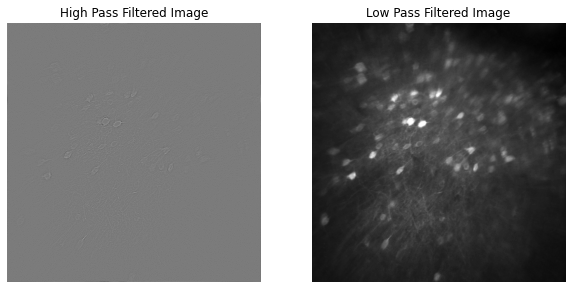

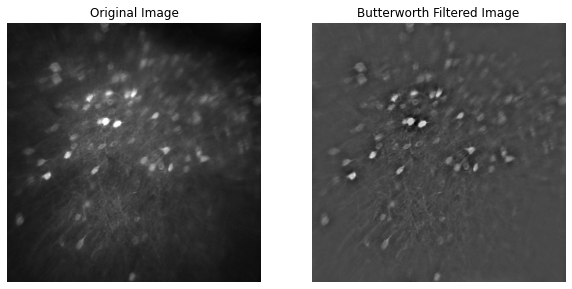

In [8]:
(imHi, imLo)=gaussian_filter(im, 2) # perform gaussian filtering
imB=butterwoth_filter(im, 2, 10, 0) # perform butterworth filtering